In [ ]:
import os 
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose,
Concatenate, BatchNormalization, Dropout, Lambda)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Loss

from tensorflow.keras import backend as K
from tensorflow.keras.saving import register_keras_serializable

from patchify import patchify


In [2]:
import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.19.0


#### Load train-test data

In [3]:
from tensorflow import keras
print(f"Keras version: {keras.__version__}")

Keras version: 3.9.1


In [4]:
INPUT_DATA_FILE = '../data/training_data.pkl'

In [5]:
with open(INPUT_DATA_FILE, 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
label_map = data['label_map']
class_labels_rgb = data['class_labels_rgb']

In [6]:
NUM_IMGS, IMG_H, IMG_W, IMG_C = X_train.shape
NUM_CLASSES = len(label_map.keys())
print(f"Total number of images: {NUM_IMGS}")
print(f"Image height: {IMG_H}")
print(f"Image width: {IMG_W}")
print(f"Image channels: {IMG_C}")
print(f"Total Classes: {NUM_CLASSES}")

Total number of images: 1239
Image height: 256
Image width: 256
Image channels: 3
Total Classes: 6


#### U-NET Model

U-Net is a neural network model dedicated to computer vision tasks and more particularly to semantic segmentation problems.

**Semantic Segmentation**

Semantic segmentation involves labelling each pixel in an image with a class corresponding to what is being represented. This is also known as "dense prediction" as each pixel must be predicted.

Unlike other computer vision tasks, semantic segmentation does not just produce labels and bounding boxes. It generates a high-resolution image, in which each pixel is classified.

**Applications of Semantic Segmentation**

- Autonomous vehicles require perception, planning and execution in constantly changing environments.
- Medical diagnostics
- Satellite Mapping can use semantic segmentation to detect buildings and roads for traffic management and urban planning.
- Precision Agriculture Robots can use semantic segmentation to distinguish plantation from weeds.

**Instance Segmentation** is a more advanced version. If an image shows three dogs, each dog is an instance of the class "Dog". Each will be classified separately, for example, using different colors.

The U-Net architecture is one of the most widely use neural networks for image segmentation. It is composed of two paths. The first is the contraction path, also known as the __encoder__. It is used to capture the context of an image. It is an assembly of convolution and max pooling layers for reducing the number of network parameters. The second path is the symmetric expansion path, also known as the __decoder__. It allows for accurate localization through transposed convolution.

In [7]:
def conv_block(m_input, num_filters, kernel_size, activation, kernel_initializer, padding, dropout):
    x = Conv2D(
        num_filters, kernel_size, activation=activation, 
        kernel_initializer=kernel_initializer, padding=padding
    )(m_input)
    x = Dropout(dropout)(x)
    c1 = Conv2D(
        num_filters, kernel_size, activation=activation, 
        kernel_initializer=kernel_initializer, padding=padding
    )(x)
    # x = Dropout(dropout)(x)
    return x

def encoder_block(m_input, num_filters, kernel_size, activation, kernel_initializer, padding, dropout):
    x = conv_block(m_input, 32, (3, 3), activation, kernel_initializer, padding, dropout)
    p = MaxPooling2D((2,2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters, kernel_size_t, strides, kernel_size, activation, kernel_initializer, padding, dropout):
    x = Conv2DTranspose(num_filters, kernel_size_t, strides=strides, padding=padding)(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters, kernel_size, activation, kernel_initializer, padding, dropout)
    return x

def unet_model(n_classes, image_height, image_width, image_channels, start_filters=16):

    activation = "relu"
    kernel_initializer = "he_normal"
    padding = "same"
    dropout = 0.1

    model_input = Input((image_height, image_width, image_channels))
    c1, p1 = encoder_block(model_input, start_filters, (3, 3), activation, kernel_initializer, padding, dropout)
    c2, p2 = encoder_block(p1, 2*start_filters, (3, 3), activation, kernel_initializer, padding, dropout)
    c3, p3 = encoder_block(p2, 4*start_filters, (3, 3), activation, kernel_initializer, padding, dropout)
    c4, p4 = encoder_block(p3, 6*start_filters, (3, 3), activation, kernel_initializer, padding, dropout)

    b1 = conv_block(p4, 8*start_filters, (3, 3), activation, kernel_initializer, padding, dropout)

    d1 = decoder_block(b1, c4, 6*start_filters, (2,2), (2,2), (3,3), activation, kernel_initializer, padding, dropout)
    d2 = decoder_block(d1, c3, 4*start_filters, (2,2), (2,2), (3,3), activation, kernel_initializer, padding, dropout)
    d3 = decoder_block(d2, c2, 2*start_filters, (2,2), (2,2), (3,3), activation, kernel_initializer, padding, dropout)
    d4 = decoder_block(d3, c1, start_filters, (2,2), (2,2), (3,3), activation, kernel_initializer, padding, dropout)
    
    outputs = Conv2D(n_classes, (1,1), activation="softmax", padding="same")(d4)

    return Model(model_input, outputs, name="U-Net")
    

**Evaluation Metrics**

We'll use Jaccard Index / Intersection over Union (IoU) as the evaluation metrics. The Jaccard index is a statistics used for gauging the similarity and diversity of sample sets. It is defined in general by taking the ratio of the intersection size and the union size, also called IoU.

\begin{equation}
J(A,B) = \frac{|A \cap B|}{|A \cup B|}
\end{equation}

The Jaccard distance, on the other hand, is complementary to the Jaccard Index and is obtained by subtracting the Jaccard Index from 1. It measures the dissimilarity between sample sets.

\begin{equation}
d_J(A,B) = 1 - J(A,B)
\end{equation}

In [8]:
K.flatten(y_train).shape

I0000 00:00:1748546391.371060  169563 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6073 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5
2025-05-29 15:19:51.390171: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3897556992 exceeds 10% of free system memory.


TensorShape([487194624])

In [9]:
@register_keras_serializable()
def multiclass_jaccard_index(y_true, y_pred, smooth=1e-6):
    assert y_true.shape == y_pred.shape
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    jaccard_index = (intersection + smooth) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + smooth)
    return jaccard_index
    

In [10]:
metrics = ["accuracy", multiclass_jaccard_index]

In [11]:
def get_model():
    return unet_model(NUM_CLASSES, IMG_H, IMG_W, IMG_C)

In [12]:
model = get_model()

In [13]:
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      9,248 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │      9,248 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │      9,248 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ dropout_3[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │     36,992 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │     49,248 │ dropout_4[0][0]   │
│ (Conv2DTranspose)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 341,350 (1.30 MB)

 Trainable params: 341,350 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# model.get_config()

**Loss Function**

For this exercise, we'll use a combination of dice loss and focal loss. A __Focal Loss__ function addresses class imbalance during training in tasks like object detection. Focal loss applies a modulating term to the cross entropy loss in order to focus learning on hard misclassified examples. It is a dynamically scaled cross entropy loss, where the scaling factor decays to zero as confidence in the correct class increases. Intuitively, this scaling factor can automatically down-weight the contribution of easy examples during training and rapidly focus the model on hard examples.

Formally, the Focal Loss adds a factor $(1 - p_t)^\gamma$
 to the standard cross entropy criterion. Setting $\gamma > 0$
 reduces the relative loss for well-classified examples ($p_t > 0.5$
), putting more focus on hard, misclassified examples. Here there is tunable focusing parameter $\gamma \ge 0$

\begin{equation}
FL(p_t) = -(1 - p_t)^\gamma\log(p_t)
\end{equation}

In [15]:
@register_keras_serializable()
class DiceFocalLoss(Loss):
    def __init__(self, alpha=0.25, gamma=2.0, dice_weight=0.5, focal_weight=0.5, 
                 smooth=1e-6, from_logits=False, name="dice_focal_loss", reduction = 'sum_over_batch_size'):
        super(DiceFocalLoss, self).__init__(name=name, reduction=reduction)
        self.alpha = alpha
        self.gamma = gamma
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        self.smooth = smooth
        self.from_logits = from_logits
        
    def dice_loss(self, y_true, y_pred, use_true_union=False):
        """
        Calculate Dice Loss for multiclass segmentation.
        
        Args:
            y_true: Ground truth labels (batch_size, height, width, num_classes)
            y_pred: Predicted probabilities (batch_size, height, width, num_classes)
            use_true_union: If True, uses A+B-A∩B formula; if False, uses A+B (Sørensen-Dice)
        """
        # Calculate intersection by summing over spatial dimensions (axis 1,2) for each class
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])  # Shape: (batch, num_classes)
        
        if use_true_union:
            # True set theory union: A + B - A∩B
            sum_sets = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
            union = sum_sets - intersection
        else:
            # Sørensen-Dice coefficient: A + B (more commonly used in segmentation)
            union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
        
        # Dice coefficient for each class and batch
        dice_coeff = (2.0 * intersection + self.smooth) / (union + self.smooth)
        
        # Average across classes and batches
        dice_loss = 1.0 - tf.reduce_mean(dice_coeff)
        return dice_loss
    
    def focal_loss(self, y_true, y_pred):
        """
        Calculate Focal Loss for multiclass segmentation.
        
        Args:
            y_true: Ground truth labels (batch_size, height, width, num_classes)
            y_pred: Predicted probabilities (batch_size, height, width, num_classes)
        """
        # Clip predictions to prevent log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Standard cross entropy
        ce_loss = -y_true * tf.math.log(y_pred)
        
        # For focal loss, p_t is simply the predicted probability of the true class
        # Since y_pred is already probabilities and y_true is one-hot encoded:
        p_t = tf.reduce_sum(y_true * y_pred, axis=-1, keepdims=True)  # Extract prob of true class
        
        # Apply focal loss modulation: (1-p_t)^gamma
        focal_weight = tf.pow((1 - p_t), self.gamma)
        
        # Apply class weighting (alpha) and focal weight
        focal_loss = self.alpha * focal_weight * ce_loss
        
        # Return mean loss
        return tf.reduce_mean(focal_loss)
    
    def call(self, y_true, y_pred):
        """
        Calculate combined Dice + Focal Loss.
        """
        # Convert logits to probabilities if needed
        if self.from_logits:
            y_pred = tf.nn.softmax(y_pred, axis=-1)
        
        # Calculate individual losses
        dice_loss_val = self.dice_loss(y_true, y_pred)
        focal_loss_val = self.focal_loss(y_true, y_pred)
        
        # Combine losses with weights
        total_loss = (self.dice_weight * dice_loss_val + 
                     self.focal_weight * focal_loss_val)
        
        return total_loss

In [16]:
optimizer = Adam(learning_rate=0.0005)
model.compile(
    optimizer=optimizer,
    loss=DiceFocalLoss(),
    metrics=metrics
)

#### Model Training

In [17]:
NUM_EPOCHS = 100
model_history = model.fit(X_train, y_train, batch_size=16, epochs=NUM_EPOCHS, verbose=True, validation_data=(X_test, y_test), shuffle=True)

2025-05-29 15:20:03.697736: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 974389248 exceeds 10% of free system memory.
2025-05-29 15:20:04.703084: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1948778496 exceeds 10% of free system memory.
2025-05-29 15:20:05.810678: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 974389248 exceeds 10% of free system memory.
2025-05-29 15:20:05.978680: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1948778496 exceeds 10% of free system memory.


Epoch 1/100


I0000 00:00:1748546409.836230  169846 service.cc:152] XLA service 0x7f91dc11be80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748546409.836269  169846 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-05-29 15:20:10.157548: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748546410.991485  169846 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-29 15:20:13.679151: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.30 = (f32[16,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,256,256]{3,2,1,0} %bitcast.28014, f32[32,3,3,3]{3,2,1,0} %bitcast.28021, f32[32]{0} %bitcast.29431), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_ca

77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3767 - loss: 0.4614 - multiclass_jaccard_index: 0.1940

2025-05-29 15:20:30.585904: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.30 = (f32[7,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,3,256,256]{3,2,1,0} %bitcast.28014, f32[32,3,3,3]{3,2,1,0} %bitcast.28021, f32[32]{0} %bitcast.29431), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="U-Net_1/conv2d_1/convolution" source_file="/home/jubranakram/virtual-envs/tf-ml/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-29 15:20:30.625301: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.3784 - loss: 0.4612 - multiclass_jaccard_index: 0.1951

2025-05-29 15:20:40.037742: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.30 = (f32[16,32,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,256,256]{3,2,1,0} %bitcast.1127, f32[32,3,3,3]{3,2,1,0} %bitcast.1134, f32[32]{0} %bitcast.1136), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="U-Net_1/conv2d_1/convolution" source_file="/home/jubranakram/virtual-envs/tf-ml/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-29 15:20:40.095013: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] 

78/78 ━━━━━━━━━━━━━━━━━━━━ 37s 244ms/step - accuracy: 0.3800 - loss: 0.4611 - multiclass_jaccard_index: 0.1962 - val_accuracy: 0.6199 - val_loss: 0.4197 - val_multiclass_jaccard_index: 0.4055
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.6815 - loss: 0.4124 - multiclass_jaccard_index: 0.4435 - val_accuracy: 0.7397 - val_loss: 0.3797 - val_multiclass_jaccard_index: 0.5261
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.7564 - loss: 0.3860 - multiclass_jaccard_index: 0.5488 - val_accuracy: 0.7670 - val_loss: 0.3635 - val_multiclass_jaccard_index: 0.5776
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.7773 - loss: 0.3720 - multiclass_jaccard_index: 0.5878 - val_accuracy: 0.7713 - val_loss: 0.3545 - val_multiclass_jaccard_index: 0.6029
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.8065 - loss: 0.3668 - multiclass_jaccard_index: 0.6381 - val_accuracy: 0.7817 - val_loss: 0.3479 - val_multiclass_jaccard_index: 0.6249


In [18]:
history_rec = model_history

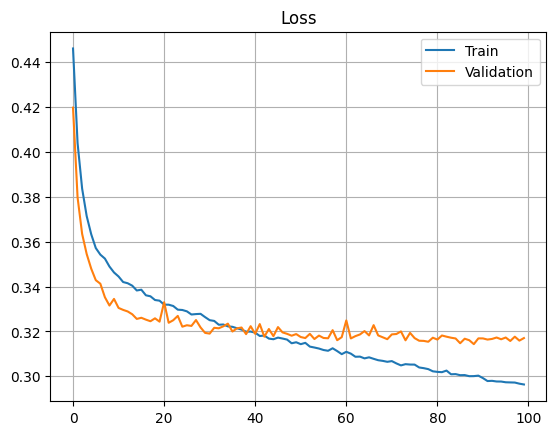

In [19]:
train_loss = history_rec.history['loss']
val_loss = history_rec.history['val_loss']
num_epochs = range(NUM_EPOCHS)

plt.plot(num_epochs, train_loss, label='Train')
plt.plot(num_epochs, val_loss, label='Validation')
plt.title('Loss')
plt.grid()
plt.legend()

In [20]:
test_image_number = np.random.randint(X_test.shape[0])

test_image = X_test[test_image_number]
y_test_argmax = np.argmax(y_test, axis=3)
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0, :, :]

2025-05-29 15:29:31.471489: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.33 = (f32[1,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,32,32]{3,2,1,0} %bitcast.558, f32[32,32,3,3]{3,2,1,0} %bitcast.565, f32[32]{0} %bitcast.567), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="U-Net_1/conv2d_6_1/convolution" source_file="/home/jubranakram/virtual-envs/tf-ml/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-29 15:29:31.590438: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitt

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


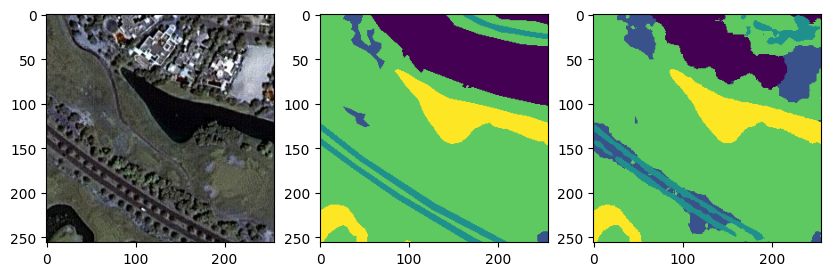

In [21]:
fig, axs = plt.subplots(1,3, figsize=(10,6))
axs = axs.flatten()

axs[0].imshow(test_image)
axs[1].imshow(ground_truth_image)
axs[2].imshow(predicted_image)

__Save Model__

In [22]:
model.save('../model/semantic-segmentation-aerial-unet-v0.keras')

In [23]:
!ls -lah ../model

total 25M
drwxr-xr-x 2 jubranakram jubranakram 4.0K May 29 10:12 .
drwxr-xr-x 7 jubranakram jubranakram 4.0K May 28 20:33 ..
-rw-r--r-- 1 jubranakram jubranakram  21M May 29 09:59 semantic-segmentation-aerial-unet-v0.h5
-rw-r--r-- 1 jubranakram jubranakram 4.1M May 29 15:29 semantic-segmentation-aerial-unet-v0.keras


In [24]:
from tensorflow.keras.models import load_model

In [25]:
saved_model = load_model('../model/semantic-segmentation-aerial-unet-v0.keras')

(1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


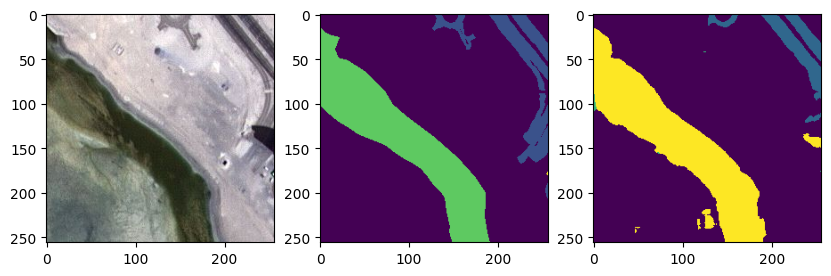

In [44]:
test_image_number = np.random.randint(X_test.shape[0])

test_image = X_test[test_image_number]
y_test_argmax = np.argmax(y_test, axis=3)
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)
print(test_image_input.shape)
prediction = saved_model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0, :, :]

fig, axs = plt.subplots(1,3, figsize=(10,6))
axs = axs.flatten()

axs[0].imshow(test_image)
axs[1].imshow(ground_truth_image)
axs[2].imshow(predicted_image)

In [27]:
#### Load image from Google

In [28]:
FILEPATH = '/mnt/d/satellite-imgs/0001.jpg'

In [29]:
image = cv2.imread(FILEPATH)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image.shape

(719, 1279, 3)

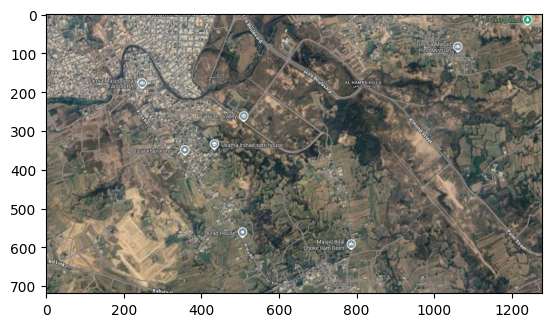

In [30]:
plt.imshow(image)

In [31]:
image.max()

255

In [32]:
image = image/255.0

In [33]:
PATCH_SIZE = 256
image_patches = patchify(image, (PATCH_SIZE, PATCH_SIZE, 3), step=PATCH_SIZE)
image_patches.shape

(2, 4, 1, 256, 256, 3)

In [37]:
image_1 = image_patches[1, 3, :, :, :]
image_1.shape

(1, 256, 256, 3)

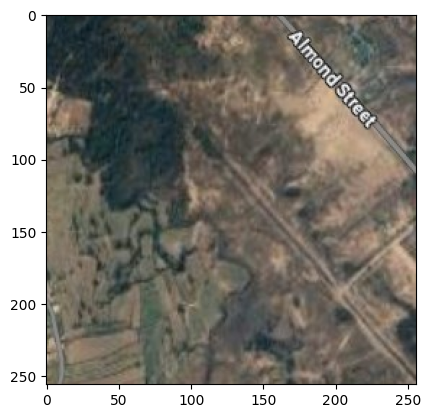

In [38]:
plt.imshow(np.squeeze(image_1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
(1, 256, 256)


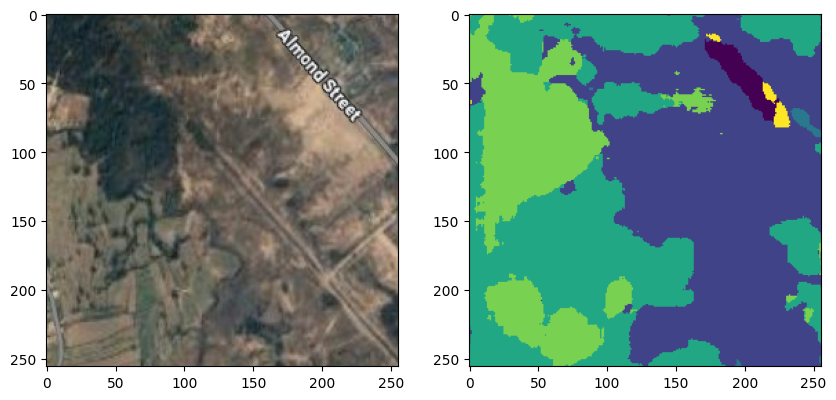

In [39]:
prediction = saved_model.predict(image_1)
predicted_image = np.argmax(prediction, axis=3)
print(predicted_image.shape)
predicted_image = predicted_image[0, :, :]

fig, axs = plt.subplots(1,2, figsize=(10,6))
axs = axs.flatten()

axs[0].imshow(np.squeeze(image_1))
axs[1].imshow(predicted_image)